In [1]:
import scipy.io as sio
import numpy as np
import os
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fname = join(os.getcwd(),'data','data3SS2009.mat') # fname = caminho da pasta com arquivo

mat_contents = sio.loadmat(fname) # mat_contents carrega todos os dados do arquivo

dataset = mat_contents['dataset'] # Armazena os dados da coluna dataset

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

y

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

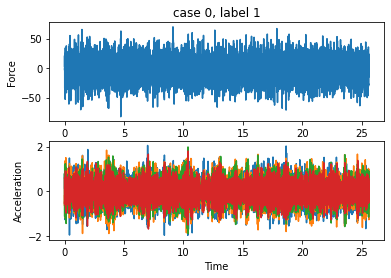

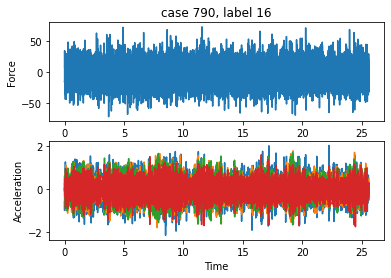

In [3]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time,Ch2[:,case],time,Ch3[:,case],time,Ch4[:,case],time,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

In [4]:
# Exercício 4.a.a

#loop feito para cada canal e cada sequência de medidas
#Importações indicadas no tutorial da página
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg  

Channels = [Ch2, Ch3, Ch4, Ch5]
X1 = []
n_lag = 30

for Channel in Channels:
    parameters = []
    for case in range(Nc):
        AR_Ch = AutoReg(Channel[:,case],lags=n_lag).fit()
        parameters.append(AR_Ch.params)
    parameters = np.vstack(tuple(parameters))
    print('Output shape = {}'.format(parameters.shape))
    X1.append(parameters)

X1 = np.hstack(X1)
X1.shape #Formato da matriz final

Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)
Output shape = (850, 31)


(850, 124)

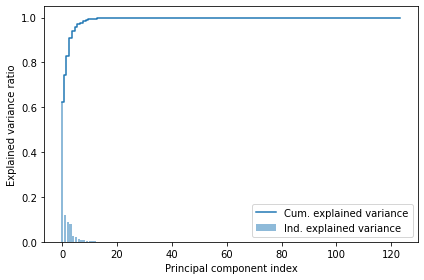

(850, 10)

In [5]:
# Exercício 4.a.b
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X1)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_variance = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center',label='Ind. explained variance')
plt.step(range(0,len(cum_sum_variance)), cum_sum_variance, where='mid', label='Cum. explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

X1_reduced=pca.fit_transform(X1)
componentes=len(cum_sum_variance[cum_sum_variance<0.99])
X2=X1_reduced[:,0:componentes]
X2.shape

# X3 -> T2(T1(X3)) -> OUTPUT (1 a 17)

In [6]:
# Exercício 4.b

# Utilizando métodos descritos em:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
# E no slide 12 da aula 2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
X1s = scaler.fit_transform(X1)
X2s = scaler.fit_transform(X2)

indDam = y > 9

dfARed = pd.concat([pd.DataFrame(X1s),pd.DataFrame({'target':indDam})], axis=1)
dfPCA = pd.concat([pd.DataFrame(X2s),pd.DataFrame({'target':indDam})], axis=1)

dfPCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,-0.252236,-0.312300,-0.234238,-0.012273,-0.129277,-0.010447,-0.085838,-0.070841,-0.195128,-0.051741
std,0.582294,0.450444,0.235347,0.427869,0.369069,0.354312,0.367903,0.350867,0.289218,0.342014
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.820990,-0.605487,-0.402430,-0.285883,-0.381873,-0.189913,-0.359643,-0.277146,-0.345575,-0.254795
50%,-0.425344,-0.470663,-0.246178,0.038969,-0.206845,-0.028918,-0.119966,-0.071913,-0.167205,-0.007364
75%,0.352590,-0.222251,-0.077246,0.292005,0.141888,0.149019,0.141957,0.119499,-0.040920,0.172722
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
# Exercício aula 6

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.manifold import TSNE

In [90]:
# Utilizando o KMeans

pctHoldout = 0.4
kfolds =  5
nkiter = 50
n_search_iter = 10

X_train, X_test, y_train, y_test = train_test_split(X2s,y, test_size=pctHoldout, random_state=42) 


In [91]:
# Exercício Aula 5 

kmeans = KMeans(n_clusters=17,random_state=0).fit(X_train)
y_predicted = kmeans.fit_predict(X_train)

y_predicted, y_train
# O KMeans gerou labels para os 17 clusters, mas com índices não correspondentes. Ex.: o label 5 do KMeans pode não
# ser o estado 5 do y.

(array([16,  2, 16, 16,  7,  3, 14, 10,  1,  1,  3,  8, 15,  3, 15,  1, 15,
         0, 15,  7, 10, 16, 16,  6,  0,  6,  6,  5,  4, 14,  6,  5,  7,  1,
        16,  4, 16,  5,  4,  8, 14,  8, 13,  7, 14,  4,  4,  9, 14,  2, 10,
         0,  3,  1, 13,  3,  9, 10, 10,  0,  9, 10,  3,  0, 12, 10,  4,  9,
        14, 11, 11,  1,  0,  4, 16,  8,  6, 14,  5, 10, 11,  0,  1, 11,  4,
        15, 14, 14,  0,  7, 15, 11, 13, 10,  2, 12,  5,  0, 15,  7,  6,  7,
        14, 16,  7,  5, 14,  0,  3,  8, 14, 11,  9,  1, 14, 11,  6, 15,  2,
         8, 15,  3,  7, 10,  9,  8, 11, 11,  1, 14,  3, 10,  9,  7,  6,  8,
        10,  7,  5,  2, 11, 14,  5, 14, 11,  5,  0,  7, 16,  3,  1,  7,  5,
         2, 16,  6,  6,  7,  5, 16, 12,  3, 10, 16,  3,  4,  0, 14,  6, 15,
         0, 14,  2, 14,  3,  0, 10, 16, 11,  7,  0, 15,  8,  3, 11, 10,  3,
         7,  1, 12, 13, 15, 15, 10,  8, 16,  2,  3,  1,  3, 16, 10, 16,  8,
        10, 14, 14,  0,  8,  4, 16,  1,  6,  5,  4, 16,  8,  5, 14,  8, 14,
        12, 

In [92]:
labels_corr = {} #Array com os labels correspondentes do KMeans para cada estado de y
aux = {} #Array auxiliar para fazer as labels do KMeans ficarem iguais às labels de y
for pred in np.unique(y_train): #Varrendo todos os 17 clusters
    moda = stats.mode(y_predicted[y_train == pred])[0][0] #Checa qual label o y_predicted mais alocou para cada estado
    #Ex.: o estado 1 da saída y recebeu o label 3 na maior parte dos casos do y_predicted.
    labels_corr[pred] = moda # Aloca para o labels_corr[n] o valor que mais teve correspondências em y.
    aux[pred] = y_predicted == moda
    
    
y_predicted_corrigido = y_predicted.copy()

for pred in labels_corr.keys():
    y_predicted_corrigido[filt[pred]] = pred #Faz com os labels correspondentes sejam iguais aos de Y.
    
# labels_corr
y_predicted_corrigido

array([ 1, 16,  1,  1,  7,  4, 14, 11, 14, 14,  4, 17, 11,  4, 12, 14, 12,
        6, 12,  7, 11,  1,  1,  9,  6,  9,  9,  8,  5, 14,  9,  8,  7, 14,
        1,  5,  1,  8,  5, 17, 15, 17, 13,  7, 15,  5,  5,  2, 15, 16, 17,
        6,  4, 14, 13,  4,  2, 11, 11,  6,  2, 17,  4,  6, 13, 11,  5,  2,
       14,  3,  3, 14,  6,  5,  1, 17,  9, 15,  8, 11,  3,  6, 14,  3,  5,
       12, 15, 15,  6,  7, 12,  3, 13, 11, 16, 13,  8,  6, 12,  7,  9,  7,
       15,  1,  7,  8, 15,  6,  4, 17, 14,  3,  2, 14, 14,  3,  9, 12, 16,
       17, 12,  4,  7, 11,  2, 17,  3,  3, 14, 14,  4, 12,  2,  7,  9, 17,
       11,  7,  8, 16,  3, 15,  8, 12,  3,  8,  6,  7,  1,  4, 14,  7,  8,
       16,  1,  9,  9,  7,  8,  1, 13,  4, 11,  1,  4,  5,  6, 15,  9, 12,
        6, 14, 16, 15,  4,  6, 11,  1,  3,  7,  6, 12, 17,  4,  3, 11,  4,
        7, 14, 13, 13, 12, 12, 11, 17,  1, 16,  4, 14,  4,  1, 12,  1, 13,
       11, 14, 15,  6, 17,  5,  1, 14,  9,  8,  5,  1, 17,  8, 15, 17, 15,
       13,  4, 16, 15, 11

In [93]:
#Precisão
(y_predicted_corrigido == y_train).sum()/len(y_train)

0.888235294117647

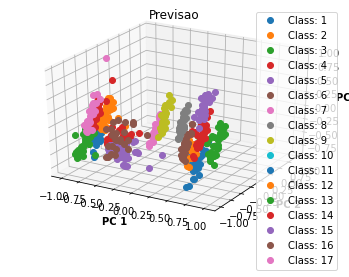

In [94]:
#Preparando a visualização 3D
fig = plt.figure()

ax = plt.axes(projection ='3d')
for pred in labels_corr.keys():
    X_train_aux = X_train[y_predicted_corrigido == pred,:3]
    ax.plot3D(X_train_aux[:,0], X_train_aux[:,1], X_train_aux[:,2], 'o', label='Class: {}'.format(pred))
    
ax.set_title("Previsao")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
ax.legend()

In [99]:
# Aplicando t-SNE
tsne = TSNE(n_components=3)

X_train_tsne = tsne.fit_transform(X_train)

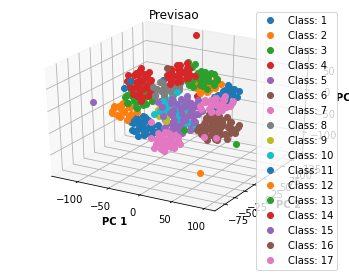

In [100]:
fig = plt.figure()

ax = plt.axes(projection ='3d')
for pred in de_para.keys():
    X_train_aux = X_train_tsne[y_train == pred,:3]
    ax.plot3D(X_train_aux[:,0], X_train_aux[:,1], X_train_aux[:,2], 'o', label='Class: {}'.format(pred))
ax.legend()

ax.set_title("Previsao")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
ax.legend()

Text(0, 0.5, 'PC 2')

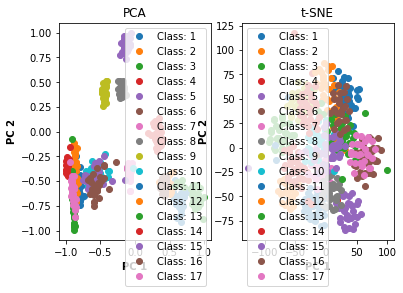

In [102]:
fig, axs = plt.subplots(1,2)

ax = axs[0]
for pred in labels_corr.keys():
    X_train_aux = X_train[y_train == pred,:3]
    ax.plot(X_train_aux[:,0], X_train_aux[:,1], 'o', label='Class: {}'.format(pred))
ax.legend()

ax.set_title("PCA")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
#ax.legend()

ax = axs[1]
for pred in de_para.keys():
    X_train_aux = X_train_tsne[y_train == pred,:3]
    ax.plot(X_train_aux[:,0], X_train_aux[:,1], 'o', label='Class: {}'.format(pred))
ax.legend()

ax.set_title("t-SNE")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
#ax.legend()

In [103]:
# Aplicando One class SVM


OCSVM = OneClassSVM(gamma='auto').fit(X_train)
y_predicted = OCSVM.predict(X_train)

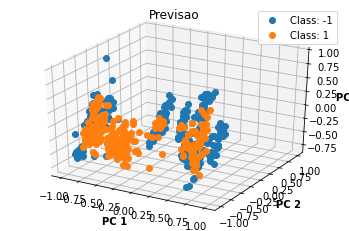

In [104]:
fig = plt.figure()
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
for pred in np.unique(y_predicted):
    X_train_aux = X_train[y_predicted == pred,:3]
    ax.plot3D(X_train_aux[:,0], X_train_aux[:,1], X_train_aux[:,2], 'o', label='Class: {}'.format(pred))
ax.legend()

ax.set_title("Previsao")
ax.set_xlabel('PC 1', fontweight ='bold')
ax.set_ylabel('PC 2', fontweight ='bold')
ax.set_zlabel('PC 3', fontweight ='bold')
ax.legend()